 # Divvy Bikeshare Data Science Notebook
 
 ### Introduction

### Environment Setup
Goals:
 * Set up colab upload functionality so that kaggle API key can be hidden
 * Add API key to environment and change permissions
 * Download dataset through kaggle CLI
 * Create data location for project
 * Decompress data
 * Install basemap to system

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/

!kaggle config set -n path -v /content 

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d yingwurenjian/chicago-divvy-bicycle-sharing-data

!mkdir /content/divvy
!mkdir /content/divvy/data
!cp -r /content/datasets/yingwurenjian/chicago-divvy-bicycle-sharing-data /content/divvy/data

!ls /content/divvy/data

!unzip \
/content/divvy/data/chicago-divvy-bicycle-sharing-data/chicago-divvy-bicycle-sharing-data.zip \
-d /content/divvy/data/

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
  
!pip install pyproj==1.9.6

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes
- path is now set to: /content
 98% 617M/629M [00:10<00:00, 48.8MB/s]
100% 629M/629M [00:10<00:00, 62.8MB/s]
chicago-divvy-bicycle-sharing-data
Archive:  /content/divvy/data/chicago-divvy-bicycle-sharing-data/chicago-divvy-bicycle-sharing-data.zip
  inflating: /content/divvy/data/data_raw.csv  
  inflating: /content/divvy/data/data.csv  
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 

     |████████████████████████████████| 2.8MB 41.8MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702062 sha256=a41c9a4f09ef87cd2cf9ecaedef5cebf64eb6a71201a5a1b5f9fc92383c6bf84
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.2.1
    Uninstalling pyproj-2.2.1:
      Successfully uninstalled pyproj-2.2.1


### Imports
For the most part generic data science libraries. Specific comments for any that are of note.

In [0]:
import os
import sys
import time
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

### Importing and Reading CSV Data

Get some basic information on the kaggle dataset

In [3]:
csv_filename = '/content/divvy/data/data.csv'
data_df = pd.read_csv(csv_filename)
data_df.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,10.066667,68.0,tstorms,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,4.383333,68.0,tstorms,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,2.100000,68.0,tstorms,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,58.016667,68.0,tstorms,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,10.633333,68.0,tstorms,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


### Create Frequency Distributions

Since this dataset is based on ride locations, the frequency of rides going to or from a specific location is important.
We'll create this feature by counting the frequency based on inline pandas methods and then add them to the dataframe.

In [4]:
from_freq_dict = dict(data_df['from_station_id'].value_counts(sort=False))
from_station_counts = [from_freq_dict[station_id] for station_id in data_df['from_station_id']]

to_freq_dict = dict(data_df['to_station_id'].value_counts(sort=False))
to_station_counts = [to_freq_dict[station_id] for station_id in data_df['to_station_id']]

data_df['trips_from_station'] = pd.Series(from_station_counts)
data_df['trips_to_station']   = pd.Series(to_station_counts)
data_df.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end,trips_from_station,trips_to_station
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,10.066667,68.0,tstorms,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.645980,15.0,19703,33783
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,4.383333,68.0,tstorms,282,Halsted St & Maxwell St,41.864580,-87.646930,15.0,22,May St & Taylor St,41.869482,-87.655486,15.0,20084,23992
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,2.100000,68.0,tstorms,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19.0,225,Halsted St & Dickens Ave,41.919936,-87.648830,15.0,31623,27534
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,58.016667,68.0,tstorms,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.627750,11.0,51123,25397
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,10.633333,68.0,tstorms,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,27481,50822


### Map Plotting Function

This function should allow easier plotting later in the notebook. Ideally as we manipulate conditional elements of the dataframe
we can come back to this function and plot slightly adjusted dataframes based on things like time of day or temperature.

In [0]:
def plot_map_data(df, x_column, y_column, size_column, lines=False):
    
    data_x = np.array(df[x_column])
    data_y = np.array(df[y_column])
    
    sizes = map_down(df, size_column, 100)
            
    ll_lon = -87.70
    ll_lat = 41.82

    ur_lon = -87.50
    ur_lat = 41.95

    plt.figure(figsize=(15,15))

    chicago_map = Basemap(
        llcrnrlon=ll_lon, llcrnrlat=ll_lat, urcrnrlon=ur_lon, urcrnrlat=ur_lat,        
        epsg=3435
    )
    chicago_map.arcgisimage(service='World_Street_Map', xpixels = 1500, verbose= True)

    if (lines):
        parallels = np.arange(0.,90,0.1)
        meridians = np.arange(10.,351.,0.1)
        chicago_map.drawparallels(parallels,labels=[False,True,True,False], color='white', textcolor='white')
        chicago_map.drawmeridians(meridians,labels=[True,False,False,True], color='white', textcolor='white')
    
    chicago_map.scatter(
        
        x=data_x,
        y=data_y,
        
        alpha=1.0,
        c=sizes,
        cmap='Reds',
        
        s=20,
        marker='.',
        
        latlon=True
    )
    
def map_down(df, size_column, scale=10):
    
    sizes = df[size_column]
    max_size = sizes.max()
    sizes = sizes * scale / max_size
    
    return sizes

http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=1156882.7636211938,1877634.5348880386,1210938.7203959061,1925471.9170457697&bboxSR=3435&imageSR=3435&size=1500,1327&dpi=96&format=png32&transparent=true&f=image


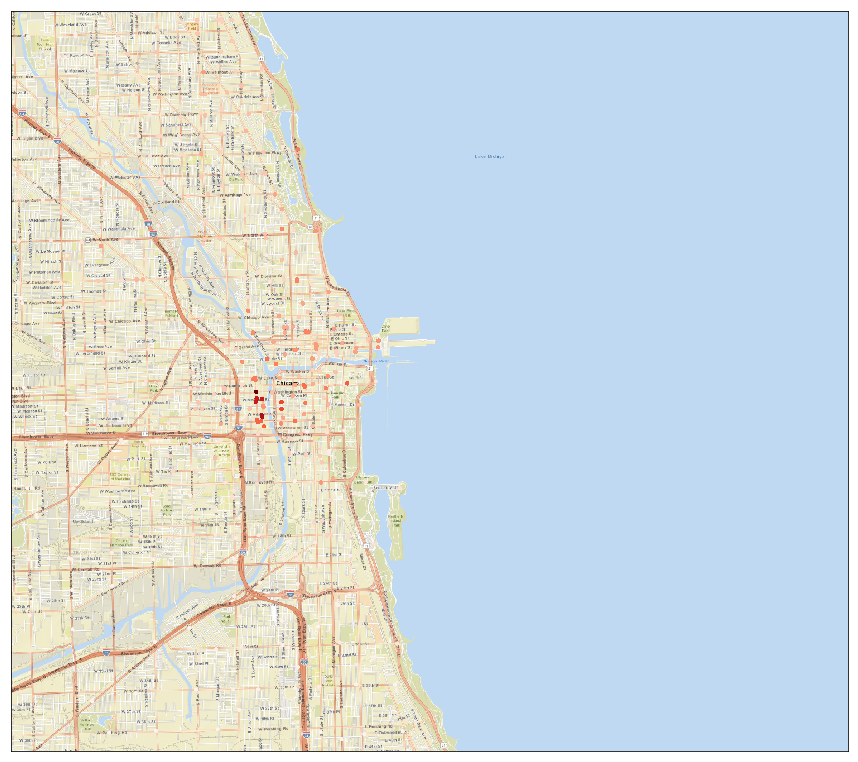

In [12]:
plot_map_data(
    data_df,
    x_column='longitude_start',
    y_column='latitude_start',
    size_column='trips_from_station'
)